In [ ]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

In [ ]:
from utils import *

In [ ]:
train_set_x, train_set_y,valid_set_x, valid_set_y, test_set_x, test_set_y = load_data_with_test_one_of_k(True)
train_set_y.astype(int)
train_set_y

In [ ]:
train_set_x, train_set_y,valid_set_x, valid_set_y, test_set_x, test_set_y = load_data_with_test_one_of_k(True)

train_set_x = theano.shared(value=train_set_x.astype(dtype=theano.config.floatX), name='train_set_x')
train_set_y = theano.shared(value=train_set_y.astype(dtype=np.int32), name='train_set_y')
valid_set_x = theano.shared(value=valid_set_x.astype(dtype=theano.config.floatX), name='valid_set_x')
valid_set_y = theano.shared(value=valid_set_y.astype(dtype=np.int32), name='valid_set_y')
test_set_x = theano.shared(value=test_set_x.astype(dtype=theano.config.floatX), name='test_set_x')
test_set_y = theano.shared(value=test_set_y.astype(dtype=np.int32), name='test_set_y')
    

In [ ]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

In [ ]:
l_in= lasagne.layers.InputLayer((train_set_x.get_value(borrow=True).shape), input_var = train_set_x)

In [ ]:
l_hidden = lasagne.layers.DenseLayer(l_in, num_units=200, W=lasagne.init.Normal(0.01))

In [ ]:
l_out = lasagne.layers.DenseLayer(l_hidden, num_units = 7, nonlinearity=T.nnet.softmax)

In [ ]:
prediction = lasagne.layers.get_output(l_out)

In [ ]:
loss = lasagne.objectives.categorical_crossentropy(prediction, train_set_y)

In [ ]:
loss = loss.mean()

In [ ]:
params = lasagne.layers.get_all_params(l_out, trainable=True)

In [ ]:
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)

In [ ]:
test_prediction = lasagne.layers.get_output(l_out, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(train_set_x, train_set_y)

In [ ]:
test_loss = test_loss.mean()

In [ ]:
x = T.matrix('x')  # the data is presented as rasterized images
y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels
train_fn = theano.function(inputs=[], loss, updates=updates, givens={x:train_set_x, y:train_set_y})

In [ ]:
#!/usr/bin/env python

"""
Usage example employing Lasagne for digit recognition using the MNIST dataset.
This example is deliberately structured as a long flat file, focusing on how
to use Lasagne, instead of focusing on writing maximally modular and reusable
code. It is used as the foundation for the introductory Lasagne tutorial:
http://lasagne.readthedocs.org/en/latest/user/tutorial.html
More in-depth examples and reproductions of paper results are maintained in
a separate repository: https://github.com/Lasagne/Recipes
"""

from __future__ import print_function

import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T

import lasagne


# ################## Download and prepare the MNIST dataset ##################
# This is just some way of getting the MNIST dataset from an online location
# and loading it into numpy arrays. It doesn't involve Lasagne at all.

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test


# ##################### Build the neural network model #######################
# This script supports three types of models. For each one, we define a
# function that takes a Theano variable representing the input and returns
# the output layer of a neural network model built in Lasagne.

def build_mlp(input_var=None):
    # This creates an MLP of two hidden layers of 800 units each, followed by
    # a softmax output layer of 10 units. It applies 20% dropout to the input
    # data and 50% dropout to the hidden layers.

    # Input layer, specifying the expected input shape of the network
    # (unspecified batchsize, 1 channel, 28 rows and 28 columns) and
    # linking it to the given Theano variable `input_var`, if any:
    l_in = lasagne.layers.InputLayer(shape=(None, 32, 32),
                                     input_var=input_var)

    # Apply 20% dropout to the input data:
    l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    # We'll now add dropout of 50%:
    l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.5)

    # Another 800-unit layer:
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify)

    # 50% dropout again:
    l_hid2_drop = lasagne.layers.DropoutLayer(l_hid2, p=0.5)

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    l_out = lasagne.layers.DenseLayer(
            l_hid2_drop, num_units=7,
            nonlinearity=lasagne.nonlinearities.softmax) # change to rectify

    # Each layer is linked to its incoming layer(s), so we only need to pass
    # the output layer to give access to a network in Lasagne:
    return l_out

def build_custom_mlp(input_var=None, depth=2, width=800, drop_input=.2,
                     drop_hidden=.5):
    # By default, this creates the same network as `build_mlp`, but it can be
    # customized with respect to the number and size of hidden layers. This
    # mostly showcases how creating a network in Python code can be a lot more
    # flexible than a configuration file. Note that to make the code easier,
    # all the layers are just called `network` -- there is no need to give them
    # different names if all we return is the last one we created anyway; we
    # just used different names above for clarity.

    # Input layer and dropout (with shortcut `dropout` for `DropoutLayer`):
    network = lasagne.layers.InputLayer(shape=(None, 32, 32),
                                        input_var=input_var)
    if drop_input:
        network = lasagne.layers.dropout(network, p=drop_input)
    # Hidden layers and dropout:
    nonlin = lasagne.nonlinearities.rectify
    for _ in range(depth):
        network = lasagne.layers.DenseLayer(
                network, width, nonlinearity=nonlin)
        if drop_hidden:
            network = lasagne.layers.dropout(network, p=drop_hidden)
    # Output layer:
    softmax = lasagne.nonlinearities.softmax
    network = lasagne.layers.DenseLayer(network, 7, nonlinearity=softmax)
    return network


def build_cnn(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


# ############################## Main program ################################
# Everything else will be handled in our main program now. We could pull out
# more functions to better separate the code, but it wouldn't make it any
# easier to read.

def main(model='custom_mlp:4,800,0.2,0.5', num_epochs=500):
    # Load the dataset
    print("Loading data...")
#     X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
    X_train, y_train, X_val, y_val, X_test, y_test = load_data_with_test_32x32()

     # Prepare Theano variables for inputs and targets
    input_var = T.tensor3('inputs')
    target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    if model == 'mlp':
        network = build_mlp(input_var)
    elif model.startswith('custom_mlp:'):
        depth, width, drop_in, drop_hid = model.split(':', 1)[1].split(',')
        network = build_custom_mlp(input_var, int(depth), int(width),
                                   float(drop_in), float(drop_hid))
    elif model == 'cnn':
        network = build_cnn(input_var)
    else:
        print("Unrecognized model type %r." % model)
        return

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(np.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 10, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets-1)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 1, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets-1)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 10, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))

    # Optionally, you could now dump the network weights to a file like this:
    # np.savez('model.npz', *lasagne.layers.get_all_param_values(network))
    #
    # And load them again later on like this:
    # with np.load('model.npz') as f:
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # lasagne.layers.set_all_param_values(network, param_values)

In [ ]:
import sys
import os
import time
main()

In [ ]:
#!/usr/bin/env python

"""
Usage example employing Lasagne for digit recognition using the MNIST dataset.
This example is deliberately structured as a long flat file, focusing on how
to use Lasagne, instead of focusing on writing maximally modular and reusable
code. It is used as the foundation for the introductory Lasagne tutorial:
http://lasagne.readthedocs.org/en/latest/user/tutorial.html
More in-depth examples and reproductions of paper results are maintained in
a separate repository: https://github.com/Lasagne/Recipes
"""

from __future__ import print_function

import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T

import lasagne


# ################## Download and prepare the MNIST dataset ##################
# This is just some way of getting the MNIST dataset from an online location
# and loading it into numpy arrays. It doesn't involve Lasagne at all.

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test


# ##################### Build the neural network model #######################
# This script supports three types of models. For each one, we define a
# function that takes a Theano variable representing the input and returns
# the output layer of a neural network model built in Lasagne.

def build_mlp(input_var=None):
    # This creates an MLP of two hidden layers of 800 units each, followed by
    # a softmax output layer of 10 units. It applies 20% dropout to the input
    # data and 50% dropout to the hidden layers.

    # Input layer, specifying the expected input shape of the network
    # (unspecified batchsize, 1 channel, 28 rows and 28 columns) and
    # linking it to the given Theano variable `input_var`, if any:
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                     input_var=input_var)

    # Apply 20% dropout to the input data:
    l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    # We'll now add dropout of 50%:
    l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.5)

    # Another 800-unit layer:
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify)

    # 50% dropout again:
    l_hid2_drop = lasagne.layers.DropoutLayer(l_hid2, p=0.5)

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    l_out = lasagne.layers.DenseLayer(
            l_hid2_drop, num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    # Each layer is linked to its incoming layer(s), so we only need to pass
    # the output layer to give access to a network in Lasagne:
    return l_out

# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


# ############################## Main program ################################
# Everything else will be handled in our main program now. We could pull out
# more functions to better separate the code, but it wouldn't make it any
# easier to read.

def main(model='mlp', num_epochs=500):
    # Load the dataset
    print("Loading data...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    if model == 'mlp':
        network = build_mlp(input_var)
    else:
        print("Unrecognized model type %r." % model)
        return

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()

    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))

    # Optionally, you could now dump the network weights to a file like this:
    # np.savez('model.npz', *lasagne.layers.get_all_param_values(network))
    #
    # And load them again later on like this:
    # with np.load('model.npz') as f:
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # lasagne.layers.set_all_param_values(network, param_values)

In [ ]:
main()

In [ ]:
import lasagne
import theano
import theano.tensor as T

# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        
def main_ex():
    X_train, y_train, X_val, y_val, X_test, y_test = load_data_with_test_32x32()

    # create Theano variables for input and target minibatch
    input_var = T.tensor3('X')
    target_var = T.ivector('y')

    # create a small convolutional neural network
    from lasagne.nonlinearities import leaky_rectify, softmax
    network = lasagne.layers.InputLayer((None, 32, 32), input_var)
    network = lasagne.layers.DenseLayer(network, num_units=800, W=lasagne.init.Normal(0.01))
    network = lasagne.layers.DenseLayer(network, num_units=100, W=lasagne.init.Normal(0.01))
    network = lasagne.layers.DenseLayer(network, num_units=21, W=lasagne.init.Normal(0.01))
    network = lasagne.layers.DenseLayer(network, num_units=7, nonlinearity=softmax)
#     network = lasagne.layers.Conv2DLayer(network, 64, (3, 3),
#                                          nonlinearity=leaky_rectify)
#     network = lasagne.layers.Conv2DLayer(network, 32, (3, 3),
#                                          nonlinearity=leaky_rectify)
#     network = lasagne.layers.Pool2DLayer(network, (3, 3), stride=2, mode='max')
#     network = lasagne.layers.DenseLayer(lasagne.layers.dropout(network, 0.5),
#                                         128, nonlinearity=leaky_rectify,
#                                         W=lasagne.init.Orthogonal())
#     network = lasagne.layers.DenseLayer(lasagne.layers.dropout(network, 0.5),
#                                         7, nonlinearity=softmax)

    # create loss function
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean() + 1e-4 * lasagne.regularization.regularize_network_params(
            network, lasagne.regularization.l2)

    # create parameter update expressions
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01,
                                                momentum=0.9)

    # compile training function that updates parameters and returns training loss
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
            
    # Compute the test accuracy 
    test_acc = T.mean(T.eq(T.argmax(prediction, axis=1), target_var),
                      dtype=theano.config.floatX)
    
    test_loss = lasagne.objectives.categorical_crossentropy(prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    
    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

    # train network (assuming you've got some training data in numpy arrays)
    for epoch in range(1000):
        loss = 0
        train_batches = 0
        for batch in iterate_minibatches(X_train, y_train, 100, shuffle=True):
            inputs, targets = batch
            loss += train_fn(inputs, targets-1)
            train_batches += 1
#         for input_batch, target_batch in training_data:
#             loss += train_fn(input_batch, target_batch)
        print("Epoch %d: Loss %g" % (epoch + 1, loss / len(X_train)))

#     # use trained network for predictions
#     test_prediction = lasagne.layers.get_output(network, deterministic=True)
#     predict_fn = theano.function([input_var], T.argmax(test_prediction, axis=1))
#     print("Predicted class for first test input: %r" % predict_fn(test_data[0]))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 10, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets-1)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))


In [ ]:
main_ex()

In [ ]:
np.info(np.convolve)

In [ ]:
np.info(np.std)

In [ ]:
train_set_x, train_set_y,valid_set_x, valid_set_y, test_set_x, test_set_y = load_data_with_test(True)

In [37]:
import matplotlib.pyplot as plt
plt.ion()
%matplotlib inline
def ShowMeans(means):
  """Show the cluster centers as images."""
  plt.figure() # HC: Removed '1' inside figure so it creates a new figure each time.
  plt.clf()
  for i in xrange(means.shape[0]):
    plt.subplot(1, means.shape[0], i+1)
    plt.imshow(means[i, :].reshape(32, 32), cmap=plt.cm.gray)
  plt.draw()
  plt.show() # HC: Added show line
  # raw_input('Press Enter.')

In [ ]:
train_set_x[0:1].shape

In [ ]:
ShowMeans(train_set_x[0:1])

In [ ]:
ShowMeans(train_set_x[3:6])

In [ ]:
import scipy

In [2]:
def region_std(source,rec_size):
    # Compute the standard deviation in the 2*rec_size + 1 x 2*rec_size+1 square around each pixel
    row, col = source.shape
    output = np.zeros(source.shape)
    for r in range(row):
        for c in range(col):
            output[r,c] = np.std(source[max(0,r-rec_size):min(row,r+rec_size+1),max(0,c-rec_size):min(col,c+rec_size+1)])
    return output

def region_filter(source,filter):
    # Compute the output when convolved 2D source with the 2D filter
    row, col = source.shape
    row_f, col_f = filter.shape
    rec_size = (row_f-1)/2
    output = np.zeros(source.shape)
    for r in range(row_f/2, row-row_f/2):
        for c in range(col_f/2, col-col_f/2):
            output[r,c] = (source[max(0,r-rec_size):min(row,r+rec_size+1),max(0,c-rec_size):min(col,c+rec_size+1)]*filter[:,:]).mean() # Get the slice of the filter accordingly
    return output

In [ ]:
input = np.random.uniform(size=(9,9))
input.shape
np.std(input)
np.std(input[0:2,0:2])
output = region_std(input,1)
output

In [ ]:
input = np.ones((3,3))
input2 = input*2
input3 = input*3
input4 = np.ones((2,2))
input4 *= 4
output = input2*input3
output.sum()

In [ ]:
input = np.random.uniform(size=(9,9))
filter = np.array([[1,2,1],[2,4,2],[1,2,1]])
filter

In [ ]:
output = region_filter(input, filter)

In [ ]:
output

In [ ]:
from scipy import signal

In [3]:
input = np.random.uniform(size=(9,9))
filter = np.array([[1,2,1],[2,4,2],[1,2,1]])
gaussian = filter.astype(float)/filter.sum()
grad = signal.convolve2d(train_set_x[0].reshape(32,32), gaussian, boundary='symm', mode='same')

NameError: name 'train_set_x' is not defined

In [ ]:
grad = grad.reshape(1024)

In [ ]:
output = np.zeros((1,1024))
output[0,:] = grad[:]
ShowMeans(output)

In [ ]:
std = region_std(train_set_x[0].reshape(32,32),1)
std = std.reshape(1024)

In [ ]:
output_std = np.zeros((1,1024))
output_std[0,:] = std[:]
ShowMeans(output_std)

In [ ]:
final = (train_set_x[0]-grad)/std

In [ ]:
output = np.zeros((1,1024))
output[0,:] = final[:]
ShowMeans(output)

In [ ]:
filter = np.array([[1,2,1],[2,4,2],[1,2,1]])
gaussian = filter.astype(float)/filter.sum()
grad = signal.convolve2d(train_set_x[1].reshape(32,32), gaussian, boundary='symm', mode='same')
grad = grad.reshape(1024)
std = region_std(train_set_x[1].reshape(32,32),3)
std = std.reshape(1024)
final = (train_set_x[1]-grad)/std
output = np.zeros((1,1024))
output[0,:] = final[:]
ShowMeans(output)
output_std = np.zeros((1,1024))
output_std[0,:] = std[:]
ShowMeans(output_std)
output = np.zeros((1,1024))
output[0,:] = grad[:]
ShowMeans(output)
ShowMeans(train_set_x[1])

In [ ]:
index = 3
filter = np.array([[1,4,1],[4,8,4],[1,4,1]])
gaussian = filter.astype(float)/filter.sum()
grad = signal.convolve2d(train_set_x[index].reshape(32,32), gaussian, boundary='symm', mode='same')
grad = grad.reshape(1024)
std = region_std(train_set_x[index].reshape(32,32),2)
std = std.reshape(1024)
final = (train_set_x[index]-grad)/std
output = np.zeros((1,1024))
output[0,:] = final[:]
ShowMeans(output)
output_std = np.zeros((1,1024))
output_std[0,:] = std[:]
ShowMeans(output_std)
output = np.zeros((1,1024))
output[0,:] = grad[:]
ShowMeans(output)
ShowMeans(train_set_x[index:(index+1)])

In [2]:
%matplotlib inline
from utils import *
train_inputs, train_targets, valid_inputs, valid_targets, test_inputs, test_targets = load_data_with_test_normalized(True)

Done image  0
Done image  1
Done image  2
Done image  3
Done image  4
Done image  5
Done image  6
Done image  7
Done image  8
Done image  9
Done image  10
Done image  11
Done image  12
Done image  13
Done image  14
Done image  15
Done image  16
Done image  17
Done image  18
Done image  19
Done image  20
Done image  21
Done image  22
Done image  23
Done image  24
Done image  25
Done image  26
Done image  27
Done image  28
Done image  29
Done image  30
Done image  31
Done image  32
Done image  33
Done image  34
Done image  35
Done image  36
Done image  37
Done image  38
Done image  39
Done image  40
Done image  41
Done image  42
Done image  43
Done image  44
Done image  45
Done image  46
Done image  47
Done image  48
Done image  49
Done image  50
Done image  51
Done image  52
Done image  53
Done image  54
Done image  55
Done image  56
Done image  57
Done image  58
Done image  59
Done image  60
Done image  61
Done image  62
Done image  63
Done image  64
Done image  65
Done image  66
Done 

utils.py:148: RuntimeWarning: invalid value encountered in divide
  final = (images[i,:,:] - gaussian_filter).astype(float)/std_filter


In [11]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.scorer import check_scoring

def run_Bagging(num_estimator=10, num_iter=5, include_mirror=False, do_cv=False):
    num_iter = 10
    num_estimator = 10
#     myClassifier = SGDClassifier(loss='perceptron',n_iter=num_iter)
    myClassifier = LinearSVC()
    clf = BaggingClassifier(base_estimator=myClassifier, n_estimators=num_estimator, n_jobs=-1)

    # Do just one validation
    clf.fit(train_inputs, train_targets)
    pred = clf.predict(valid_inputs)
    score = (pred == valid_targets).mean()
    print score

In [ ]:
run_Bagging()


In [7]:
train_inputs, train_targets, valid_inputs, valid_targets, test_inputs, test_targets

outfile = open('train_inputs.npy','w')
np.save(outfile,train_inputs)
outfile.close()

outfile = open('train_targets.npy','w')
np.save(outfile,train_targets)
outfile.close()

outfile = open('valid_inputs.npy','w')
np.save(outfile,valid_inputs)
outfile.close()

outfile = open('valid_targets.npy','w')
np.save(outfile,valid_targets)
outfile.close()

outfile = open('test_inputs.npy','w')
np.save(outfile,test_inputs)
outfile.close()

outfile = open('test_targets.npy','w')
np.save(outfile,test_targets)
outfile.close()

In [9]:
haha = np.load('test_targets.npy')
print haha
haha.shape

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 6 5 5 5 5 5 5
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 1 1 4 4 4 4 5 5 5 5 5 5 5
 5 5 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 4 4 1 2 2 2 2 2 2 2 2 2 2 2 3 4 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 3 1 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 2 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 5 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 4 3 4
 4 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 4 4 4 4 3 1 6 7]


(255,)

IndexError: too many indices for array

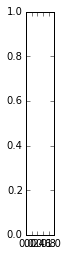

In [9]:
ShowMeans(train_inputs[0:10])

IndexError: too many indices for array

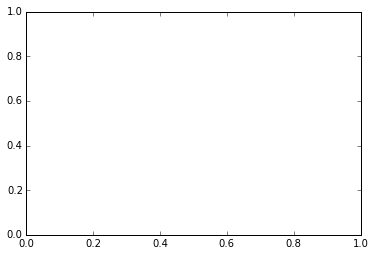

In [10]:
ShowMeans(train_inputs[0:1])

In [43]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from utils import *
# train_inputs, train_targets, valid_inputs, valid_targets, test_inputs, test_targets = reload_data_with_test_normalized()
train_inputs, train_targets, valid_inputs, valid_targets, test_inputs, test_targets = load_data_with_test(True)
pca = PCA(n_components=train_inputs.shape[1]*0.25)
train_inputs_pca = pca.fit_transform(train_inputs)
# kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
# train_inputs_kpca = kpca.fit_transform(train_inputs)

/Users/harrischan/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:301: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.noise_variance_ = explained_variance_[n_components:].mean()
/Users/harrischan/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:308: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.components_ = components_[:n_components]
/Users/harrischan/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:309: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.explained_variance_ = explained_variance_[:n_components]
/Users/harrischan/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:310: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  explained_variance_ratio_ = explain

In [44]:
train_inputs_pca.shape

(5337, 256)

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
# myClassifier = OneVsOneClassifier(SVC(gamma=0.001))
# myClassifier = SVC(gamma=0.001)
num_estimator = 25
myClassifier = BaggingClassifier(base_estimator=Perceptron(n_iter=10), n_estimators=num_estimator, n_jobs=-1)
pred = myClassifier.fit(train_inputs_pca, train_targets).predict(pca.transform(valid_inputs))
score = (pred == (valid_targets)).mean()
print score

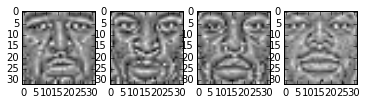

In [40]:
ShowMeans(train_inputs[60:64])

In [52]:
print valid_targets
print pred

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6 6 5 5 5 5 5
 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 4 4 4 4 5 5 5 5 5 5
 5 5 5 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 4 4 1 2 2 2 2 2 2 2 2 2 2 2 3 4 3
 3 3 3 3 3 3 3 3 4 4 4 4 4 3 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 2 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 6 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 4 3
 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 4 4 4 4 4 4 4 4 4 4 3 6 7 1]
[6 4 7 4 7 7 2 6 6 4 7 4 3 6 1 1 7 1 1 2 2 2 1 4 2 1 7 7 6 6 5 7 7 7 2 7 1
 6 3 6 3 7 6 7 3 5 7 7 6 7 7 4 6 7 7 4 3 3 6 5 7 1 1 7 4 4 4 4 7 7 7 5 7 4
 4 3 1 2 6 7 7 6 7 6 6 7 6 2 7 7 6 5 4 7 4 4 2 2 2 7 7 2 3 4 4 5 7 7 4 4 3
 3 4 6 7 7 7 7 7 1 1 4 7 4 6 3 7 4 7 3 2 2 1 1 4 2 1 7 7 4 7 7 1 1 1 4 7 7
 2 2 7 4 7 7 3 4 2 2 2 7 2 5 1 3 7 2 3 4 1 1 2 7 4 7 1 7 7 1 1 4 4 7 4 7 7
 7 1 1 1 6 7 7 4 2 7 4 4 7 4 7 5 4 1 4 4 2 3 4 1 4 1 6 1 3 5 2 7 5 7 4 2 5
 4 7 7 7 5 7 6 3 3 7 3 2 5 6 3

In [53]:
import sklearn
print("Classification report for classifier:\n%s\n"
      % (sklearn.metrics.classification_report(valid_targets, pred)))

Classification report for classifier:
             precision    recall  f1-score   support

          1       0.53      0.35      0.42        49
          2       0.33      0.26      0.29        38
          3       0.33      0.22      0.26        37
          4       0.44      0.51      0.47        45
          5       0.21      0.11      0.14        28
          6       0.76      0.33      0.46        58
          7       0.01      1.00      0.02         1

avg / total       0.47      0.32      0.36       256




In [1]:
from scipy.io import loadmat
data = loadmat('unlabeled_images.mat')

In [6]:
data['unlabeled_images'].shape

(32, 32, 98058)

In [1]:
from utils import *
unlabeled = load_unlabeled_data(True)

In [2]:
unlabeled.shape

(196116, 1024)

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=unlabeled.shape[1]*0.25)
unlabeled_pca = pca.fit_transform(unlabeled)

/Users/harrischan/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:301: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.noise_variance_ = explained_variance_[n_components:].mean()
/Users/harrischan/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:308: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.components_ = components_[:n_components]
/Users/harrischan/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:309: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.explained_variance_ = explained_variance_[:n_components]
/Users/harrischan/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:310: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  explained_variance_ratio_ = explain

In [5]:
from sklearn.ensemble import BaggingClassifier
num_estimator = 25
myClassifier = BaggingClassifier(n_estimators=num_estimator, n_jobs=-1)
pred = myClassifier.fit(unlabeled_pca, train_targets).predict(pca.transform(valid_inputs))
score = (pred == (valid_targets)).mean()
print score

NameError: name 'train_targets' is not defined

In [ ]:
from utils import *
images = load_unlabeled_data_normalized(True)

Done image  0
Done image  1
Done image  2
Done image  3
Done image  4
Done image  5
Done image  6
Done image  7
Done image  8
Done image  9
Done image  10
Done image  11
Done image  12
Done image  13
Done image  14
Done image  15
Done image  16
Done image  17
Done image  18
Done image  19
Done image  20
Done image  21
Done image  22
Done image  23
Done image  24
Done image  25
Done image  26
Done image  27
Done image  28
Done image  29
Done image  30
Done image  31
Done image  32
Done image  33
Done image  34
Done image  35
Done image  36
Done image  37
Done image  38
Done image  39
Done image  40
Done image  41
Done image  42
Done image  43
Done image  44
Done image  45
Done image  46
Done image  47
Done image  48
Done image  49
Done image  50
Done image  51
Done image  52
Done image  53
Done image  54
Done image  55
Done image  56
Done image  57
Done image  58
Done image  59
Done image  60
Done image  61
Done image  62
Done image  63
Done image  64
Done image  65
Done image  66
Done 

utils.py:402: RuntimeWarning: invalid value encountered in divide
  final = (images[i,:,:] - gaussian_filter).astype(float)/std_filter
utils.py:402: RuntimeWarning: divide by zero encountered in divide
  final = (images[i,:,:] - gaussian_filter).astype(float)/std_filter


 1836
Done image  1837
Done image  1838
Done image  1839
Done image  1840
Done image  1841
Done image  1842
Done image  1843
Done image  1844
Done image  1845
Done image  1846
Done image  1847
Done image  1848
Done image  1849
Done image  1850
Done image  1851
Done image  1852
Done image  1853
Done image  1854
Done image  1855
Done image  1856
Done image  1857
Done image  1858
Done image  1859
Done image  1860
Done image  1861
Done image  1862
Done image  1863
Done image  1864
Done image  1865
Done image  1866
Done image  1867
Done image  1868
Done image  1869
Done image  1870
Done image  1871
Done image  1872
Done image  1873
Done image  1874
Done image  1875
Done image  1876
Done image  1877
Done image  1878
Done image  1879
Done image  1880
Done image  1881
Done image  1882
Done image  1883
Done image  1884
Done image  1885
Done image  1886
Done image  1887
Done image  1888
Done image  1889
Done image  1890
Done image  1891
Done image  1892
Done image  1893
Done image  1894
Done ima

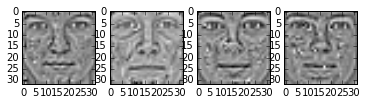

In [10]:
%matplotlib inline
def ShowMeans(means):
  """Show the cluster centers as images."""
  plt.figure() # HC: Removed '1' inside figure so it creates a new figure each time.
  plt.clf()
  for i in xrange(means.shape[0]):
    plt.subplot(1, means.shape[0], i+1)
    plt.imshow(means[i,:].reshape(32,32), cmap=plt.cm.gray)
  plt.draw()
  plt.show() # HC: Added show line
  # raw_input('Press Enter.')

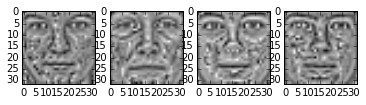

In [3]:
%matplotlib inline
def ShowMeans(means):
  """Show the cluster centers as images."""
  plt.figure() # HC: Removed '1' inside figure so it creates a new figure each time.
  plt.clf()
  for i in xrange(means.shape[0]):
    plt.subplot(1, means.shape[0], i+1)
    plt.imshow(means[i,:].reshape(32,32), cmap=plt.cm.gray)
  plt.draw()
  plt.show() # HC: Added show line
  # raw_input('Press Enter.')

ShowMeans(images[0:4])

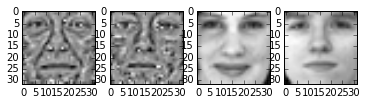

In [4]:
%matplotlib inline
def ShowMeans(means):
  """Show the cluster centers as images."""
  plt.figure() # HC: Removed '1' inside figure so it creates a new figure each time.
  plt.clf()
  for i in xrange(means.shape[0]):
    plt.subplot(1, means.shape[0], i+1)
    plt.imshow(means[i,:].reshape(32,32), cmap=plt.cm.gray)
  plt.draw()
  plt.show() # HC: Added show line
  # raw_input('Press Enter.')

ShowMeans(images[8:12])